In [1]:
import pandas as pd

df = pd.read_csv("G:/My Drive/Data-Centric Solutions/07. Blog Posts/kedro/data/creditcard.csv")

In [2]:
df['transaction_id'] = df.index

In [3]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
import glob
import os
def delete_file():
    # Get a list of all HDF5 files in the current directory
    hdf5_files = glob.glob('*.hdf5')

    # Print each HDF5 file name
    for file in hdf5_files:
        os.remove(file)

    # Get a list of all JSON files in the current directory
    json_files = glob.glob('*.json')

    # Print each JSON file name
    for file in json_files:
        os.remove(file)

In [5]:
from sdv.metadata import SingleTableMetadata
def create_metadata(df):
    df_fraud = df.loc[df["Class"] == 1]
    df_fraud.head(5)
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_fraud)

    metadata.update_column(
        column_name='transaction_id',
        sdtype='id')

    # set primary key 
    metadata.set_primary_key(column_name='transaction_id')
    metadata.validate()
    return metadata, df_fraud

In [6]:
import warnings
import numpy as np
from sdv.single_table import TVAESynthesizer
# from sdv.single_table import CTGANSynthesizer

def create_synthetic_data(metadata, df_fraud, samples):
    warnings.filterwarnings('ignore', category=FutureWarning)

    synthesizer = TVAESynthesizer(
        metadata, # required
        enforce_min_max_values=True,
        enforce_rounding=False,
        epochs=1000
    )
    synthesizer.fit(df_fraud)

    synthetic_data = synthesizer.sample(num_rows=samples)
    synthetic_data['Time'] = np.round(synthetic_data['Time'])
    
    return synthetic_data

In [7]:
from sdv.evaluation.single_table import evaluate_quality
from sdmetrics.warnings import ConstantInputWarning

def quality_check(real_data, synthetic_data):
    warnings.simplefilter(action='ignore', category=ConstantInputWarning)
    quality_report = evaluate_quality(
        real_data=real_data,
        synthetic_data=synthetic_data,
        metadata=metadata)

In [8]:
from sdv.evaluation.single_table import get_column_plot

def plot_dists(real_data, synthetic_data, column_name):
    fig = get_column_plot(
        real_data=real_data,
        synthetic_data=synthetic_data,
        column_name=column_name,
        metadata=metadata
    )

    fig.show()


In [9]:
from sklearn.model_selection import train_test_split

def split_data(df, synthetic_data, synth):

    train, holdout_df = train_test_split(df, test_size=0.2, random_state=42)
    
    train_with_synth = pd.concat([train, synthetic_data], ignore_index=True) 
    
    return train, train_with_synth, holdout_df


In [10]:
from ludwig.api import LudwigModel
import requests
import yaml


# URL of the raw YAML file in the GitHub repository
def run_experiment(url, train_df):
    url = url

    # Send a GET request to the URL
    response = requests.get(url)

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Load the YAML data from the response text
    config = yaml.safe_load(response.text)

    # Set your output directory path
    output_dir = r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns"

    # Set up your experiment
    model = LudwigModel(config=config)
    experiment_results = model.experiment(
      dataset=train_df,
      output_directory=output_dir
    )
    return model

C:\Users\johna\anaconda3\envs\synth-env\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\johna\anaconda3\envs\synth-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def analysis(model, holdout_df):
    holdout_df = holdout_df.reset_index(drop=True)
    predictions, _ = model.predict(dataset=holdout_df)

    model_analysis_df = predictions.merge(right=holdout_df, left_index=True, right_index=True)
    model_analysis_df['Class_predictions'] = model_analysis_df['Class_predictions'].map({True: 1, False: 0})
    return model_analysis_df

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def model_diagnostics(model_analysis_df, title):
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    pr_auc = auc(recall, precision)

    # Calculate F1 scores for each threshold
    f1_scores = 2*(recall * precision) / (recall + precision)
    # Get index of the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    max_precision = precision[max_f1_index]
    max_recall = recall[max_f1_index]

    # Create the Precision-Recall curve
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=recall, y=precision,
                             mode='lines',
                             name=f'PR curve (AUC = {pr_auc:.2f})'))

    # Mark the point with maximum F1 score
    fig.add_trace(go.Scatter(x=[max_recall], y=[max_precision],
                             mode='markers',
                             marker=dict(color='Red', size=10),
                             name=f'Max F1 ({max_f1:.2f})'))

    # Add annotation for precision and recall at max F1 score
    fig.add_annotation(x=max_recall, y=max_precision,
                       text=f'Precision: {max_precision:.2f}, Recall: {max_recall:.2f}',
                       showarrow=True,
                       arrowhead=1,
                       ax=0,
                       ay=-80)

    # Add random line
    no_skill = len(model_analysis_df['Class'][model_analysis_df['Class']==1]) / len(model_analysis_df['Class'])
    fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
                             mode='lines', 
                             name='No Skill', 
                             line=dict(dash='dash')))

    fig.update_xaxes(title_text="Recall")
    fig.update_yaxes(title_text="Precision", range=[0, 1])
    fig.update_layout(title_text=title, autosize=False)

    fig.show()

    # Return AUC and the values for the highest corner
    return pr_auc, max_f1, max_precision, max_recall


In [12]:
# import plotly.graph_objects as go
# from sklearn.metrics import precision_recall_curve, auc

# def model_diagnostics(model_analysis_df, title):
#     # Calculate Precision-Recall curve
#     precision, recall, _ = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
#     pr_auc = auc(recall, precision)

#     # Create the Precision-Recall curve
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=recall, y=precision,
#                              mode='lines',
#                              name=f'PR curve (AUC = {pr_auc:.2f})'))

#     # Add random line
#     no_skill = len(model_analysis_df['Class'][model_analysis_df['Class']==1]) / len(model_analysis_df['Class'])
#     fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
#                              mode='lines', 
#                              name='No Skill', 
#                              line=dict(dash='dash')))

#     fig.update_xaxes(title_text="Recall")
#     fig.update_yaxes(title_text="Precision")
#     fig.update_layout(title_text=title, autosize=False)

#     fig.show()

#     # Return AUC
#     return pr_auc

In [13]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, auc

# def model_diagnostics(model_analysis_df, title):
#     # Calculate confusion matrix
#     cm = confusion_matrix(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
#     print('Confusion Matrix:')
#     print(cm)

#     # Calculate precision, recall and F1 score
#     precision = precision_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
#     recall = recall_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
#     f1 = f1_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])

#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1 Score: {f1}')

#     # Calculate ROC curve
#     fpr, tpr, thresholds = roc_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
#     roc_auc = auc(fpr, tpr)

#     # Create subplot figure
#     fig = make_subplots(rows=1, cols=2,
#                         subplot_titles=("Confusion Matrix", "Receiver Operating Characteristic"))

#     # Add confusion matrix heatmap to subplot
#     fig.add_trace(go.Heatmap(z=cm,
#                              x=['Predicted 0', 'Predicted 1'],
#                              y=['Actual 0', 'Actual 1'],
#                              showscale=False,
#                              hoverinfo='none',  # Disable hover
#                              zauto=False,  # Custom color range
#                              zmin=0, zmax=cm.max()),
#                   row=1, col=1)

#     # Add annotations (number labels) to heatmap
#     for i in range(len(cm)):
#         for j in range(len(cm[0])):
#             fig.add_annotation(dict(font=dict(color="black",size=14),
#                                     x=j,
#                                     y=i,
#                                     showarrow=False,
#                                     text=str(cm[i][j]),
#                                     textangle=0,
#                                     xanchor='center',
#                                     yanchor='middle',
#                                     xref='x1',
#                                     yref='y1'))

#     # Add ROC curve to subplot
#     fig.add_trace(go.Scatter(x=fpr, y=tpr,
#                              mode='lines',
#                              name=f'ROC curve (area = {roc_auc:.2f})'),
#                   row=1, col=2)

#     # Add diagonal line to ROC plot
#     fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
#                              mode='lines', 
#                              name='Baseline', 
#                              line=dict(dash='dash')),
#                   row=1, col=2)

#     fig.update_xaxes(title_text="Predicted Label", row=1, col=1)
#     fig.update_yaxes(title_text="Actual Label", row=1, col=1)
#     fig.update_xaxes(title_text="False Positive Rate", row=1, col=2)
#     fig.update_yaxes(title_text="True Positive Rate", row=1, col=2)
#     fig.update_layout(title_text=title, autosize=False, width=900, height=400)

#     fig.show()


In [14]:
metadata, df_fraud = create_metadata(df)
synthetic_data = create_synthetic_data(metadata, df_fraud, samples=283823)
synth = False
train, train_with_synth, holdout_df = split_data(df, synthetic_data, synth)

Detected metadata:
{
    "columns": {
        "Time": {
            "sdtype": "numerical"
        },
        "V1": {
            "sdtype": "numerical"
        },
        "V2": {
            "sdtype": "numerical"
        },
        "V3": {
            "sdtype": "numerical"
        },
        "V4": {
            "sdtype": "numerical"
        },
        "V5": {
            "sdtype": "numerical"
        },
        "V6": {
            "sdtype": "numerical"
        },
        "V7": {
            "sdtype": "numerical"
        },
        "V8": {
            "sdtype": "numerical"
        },
        "V9": {
            "sdtype": "numerical"
        },
        "V10": {
            "sdtype": "numerical"
        },
        "V11": {
            "sdtype": "numerical"
        },
        "V12": {
            "sdtype": "numerical"
        },
        "V13": {
            "sdtype": "numerical"
        },
        "V14": {
            "sdtype": "numerical"
        },
        "V15": {
            "sdtype": "

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.76s/it]



Overall Quality Score: 93.84%

Properties:
Column Shapes: 92.58%
Column Pair Trends: 95.1%


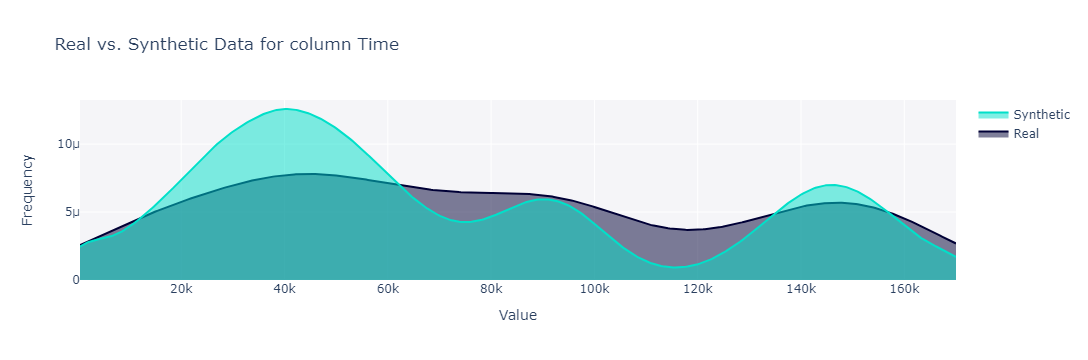

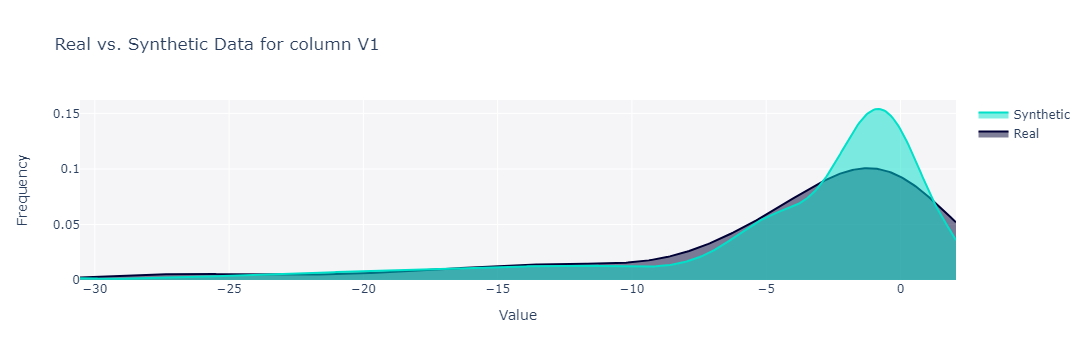

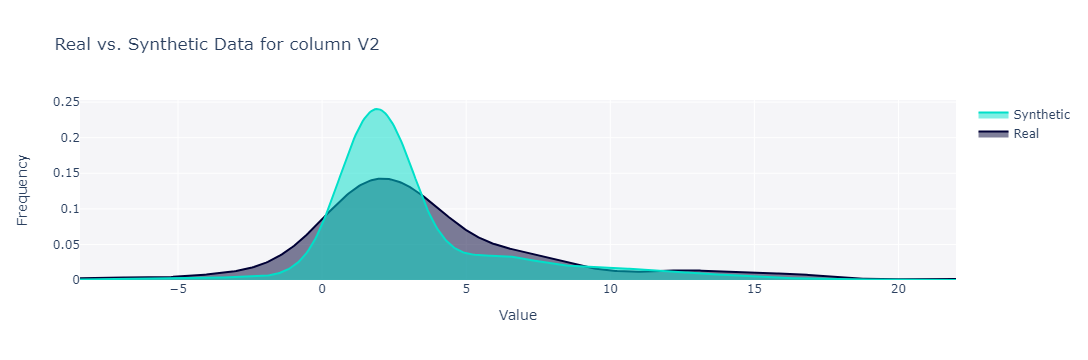

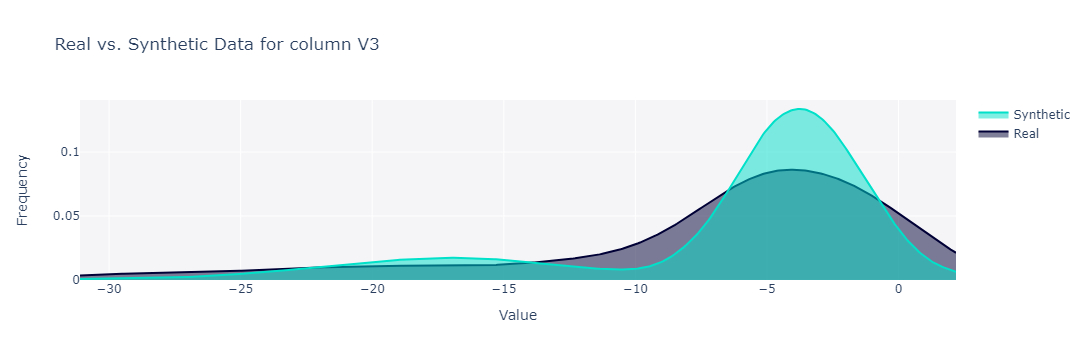

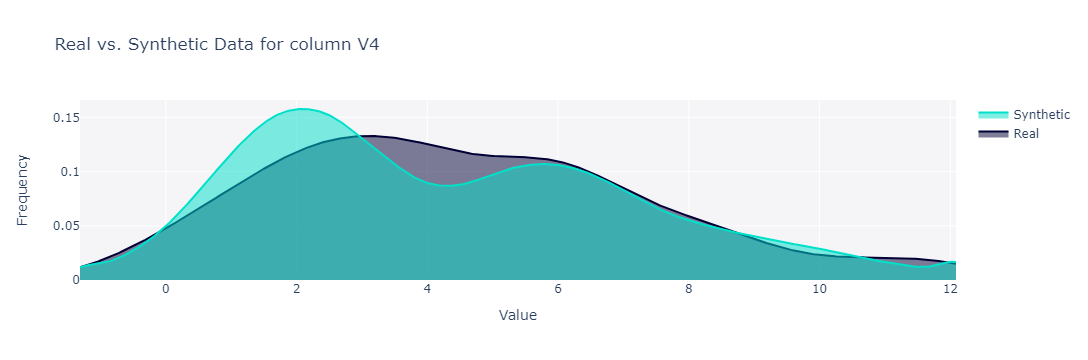

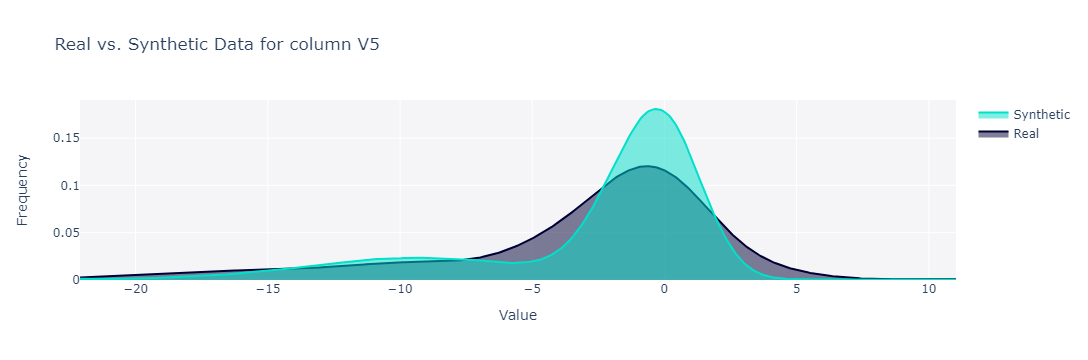

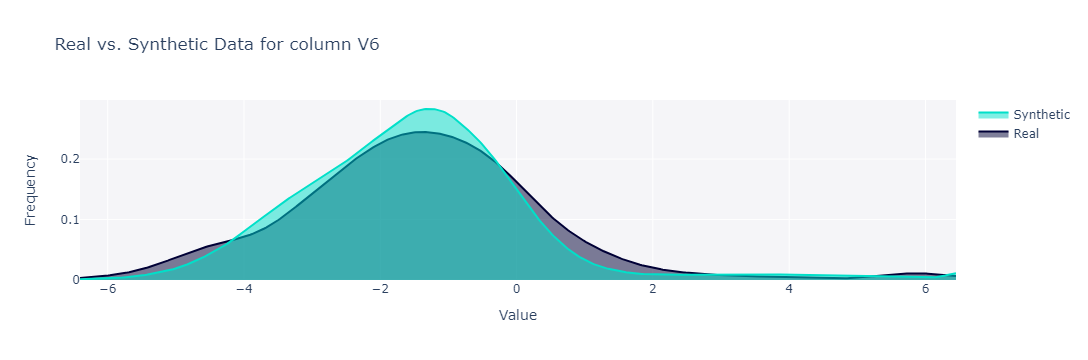

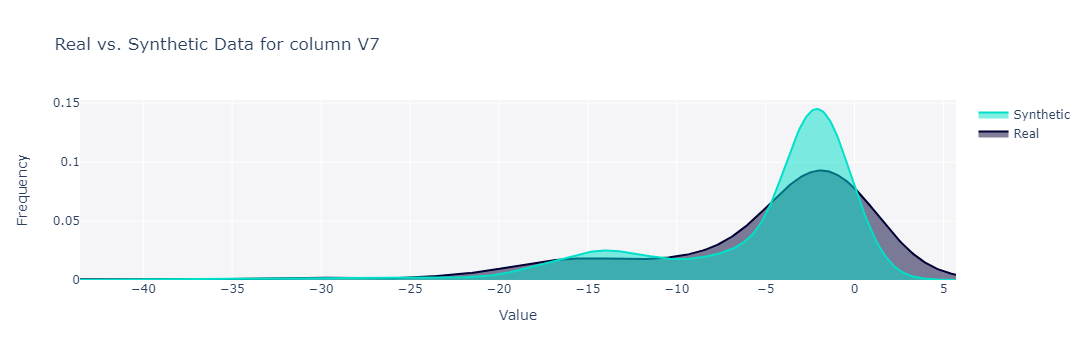

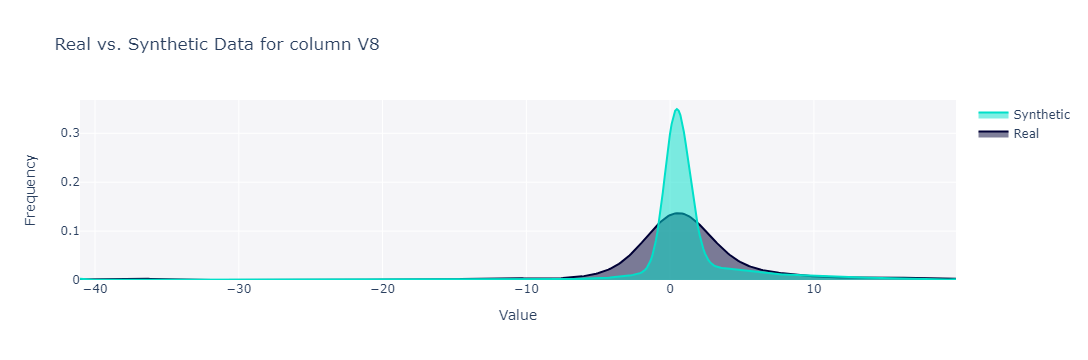

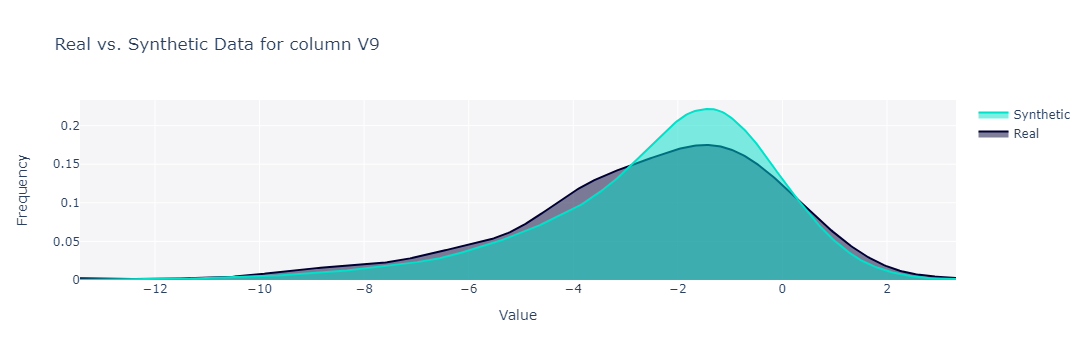

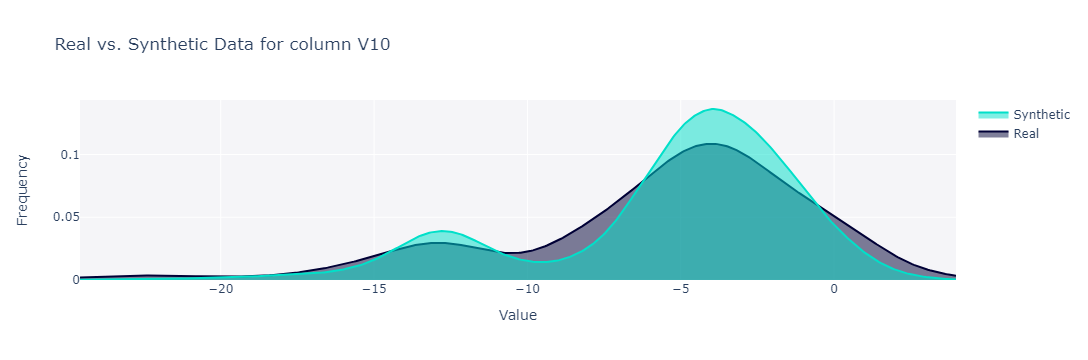

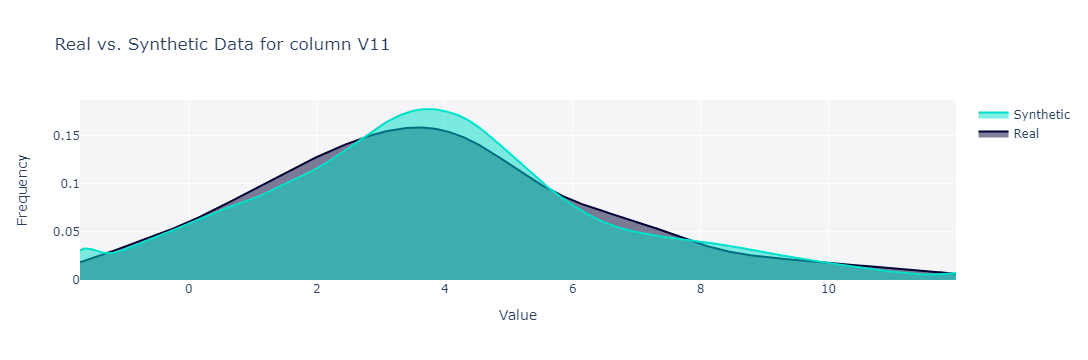

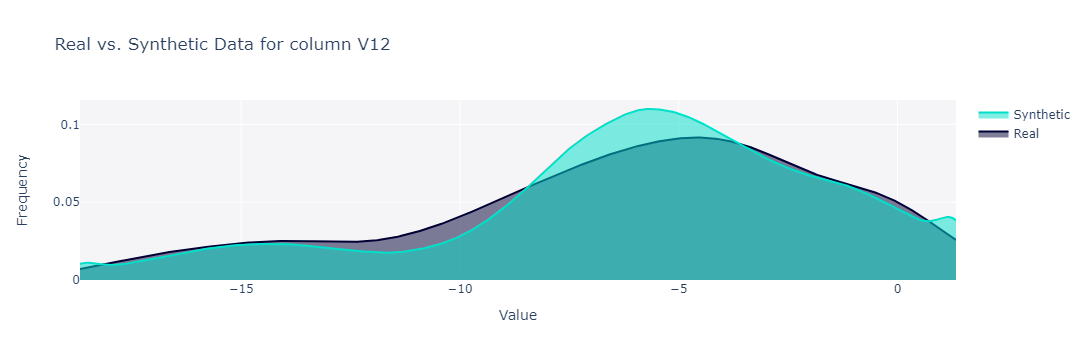

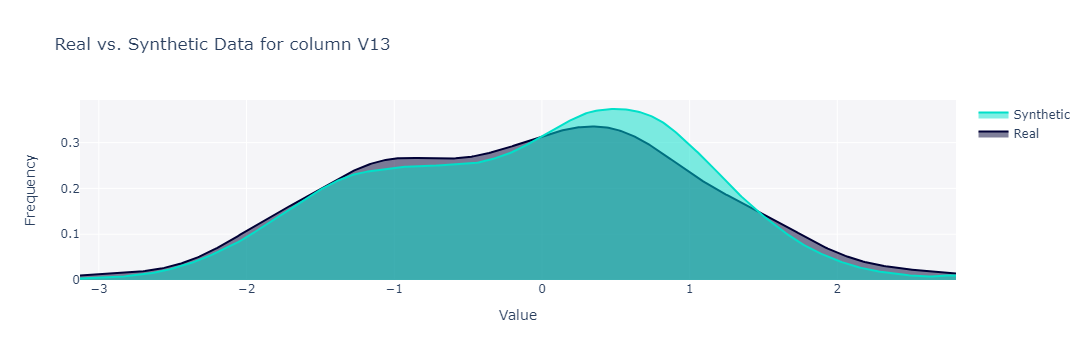

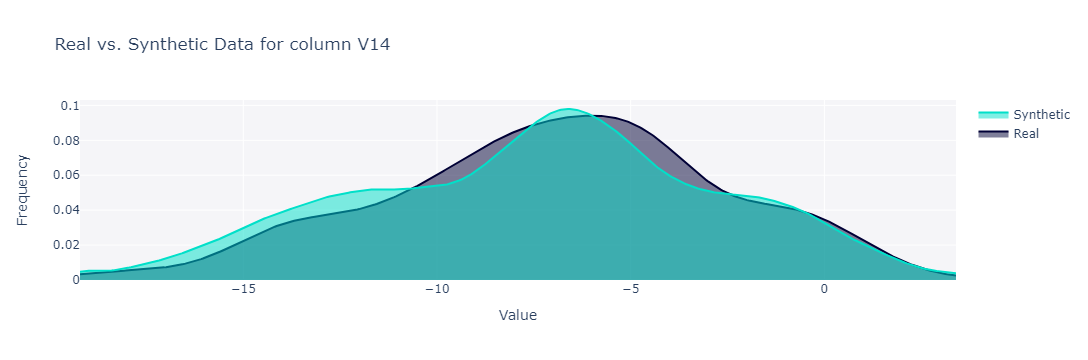

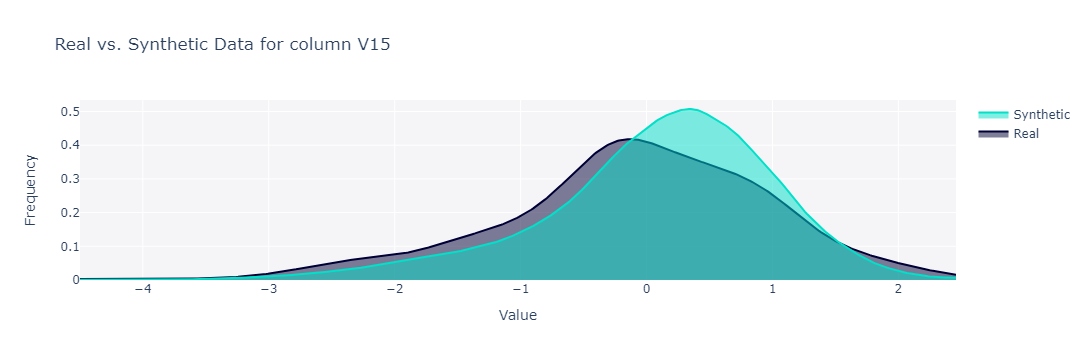

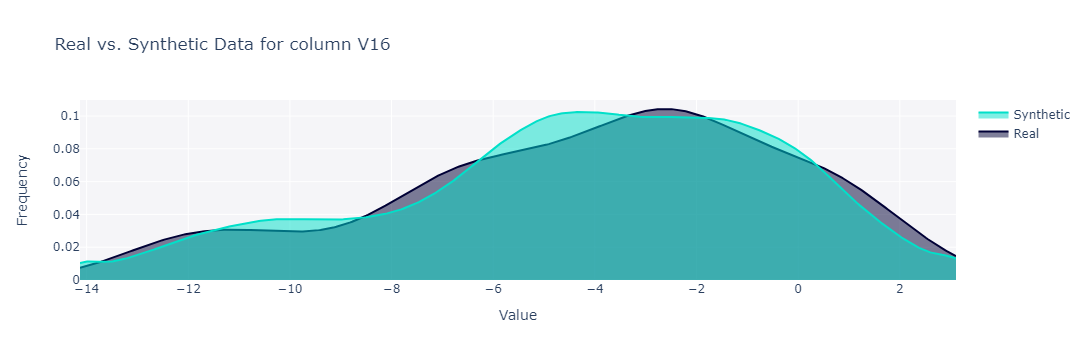

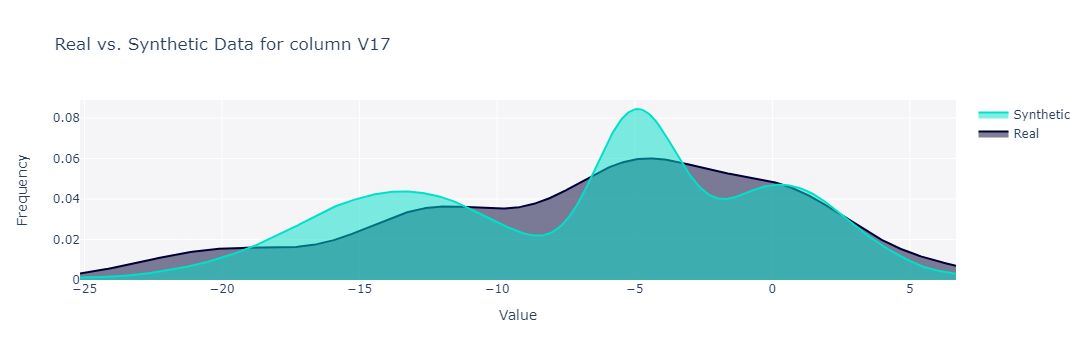

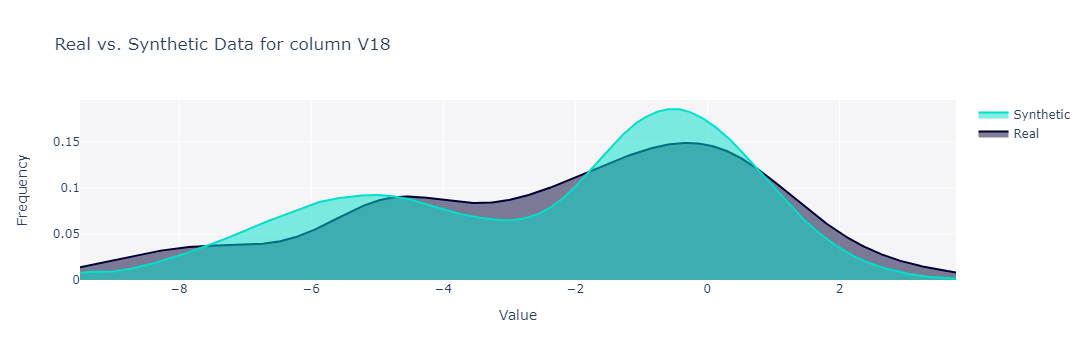

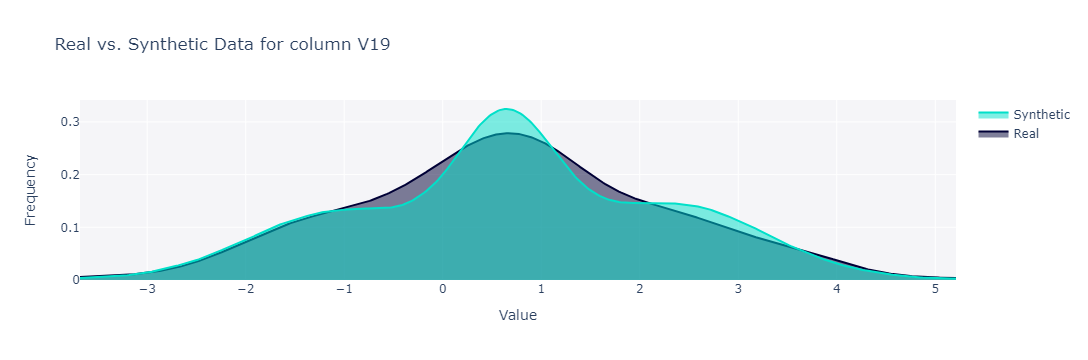

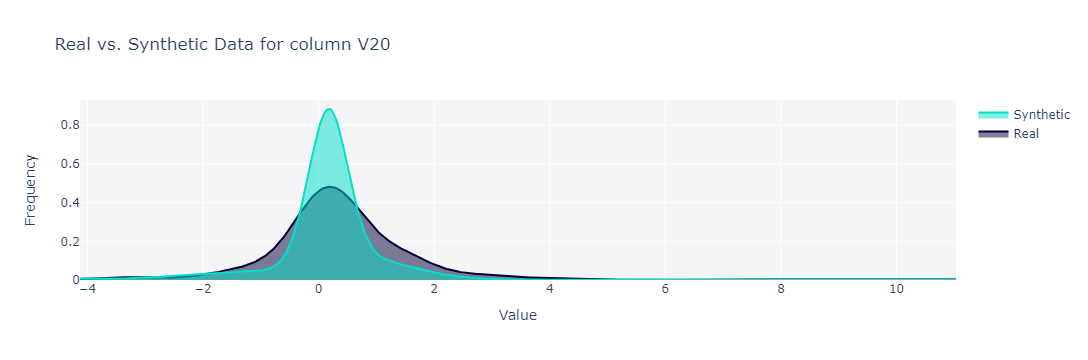

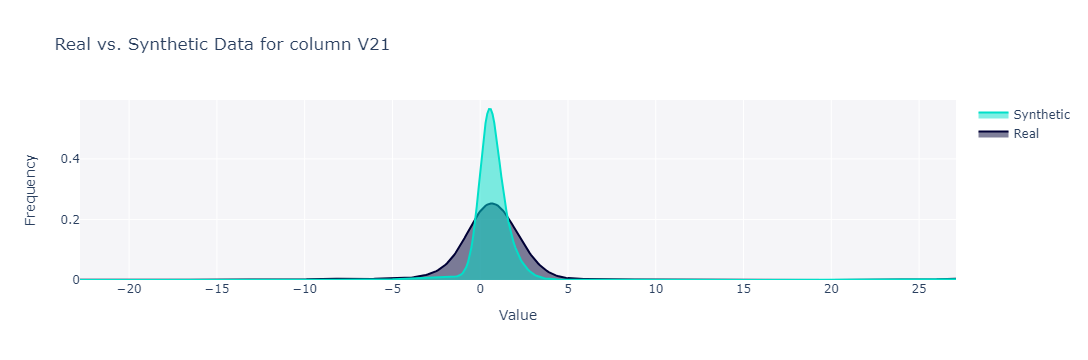

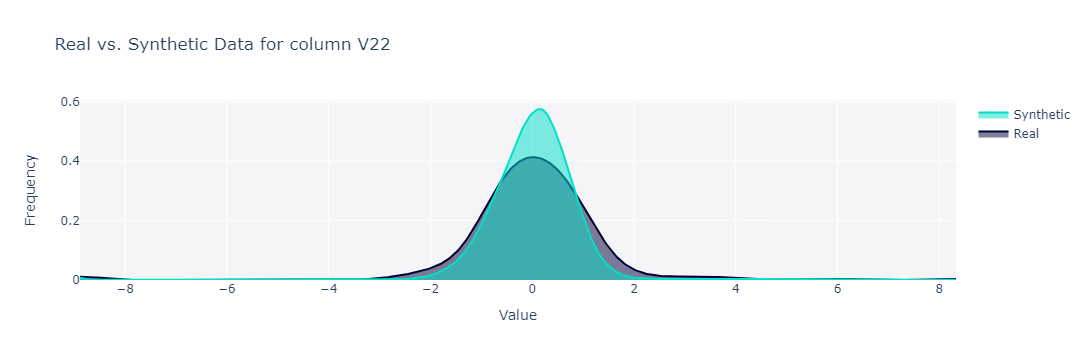

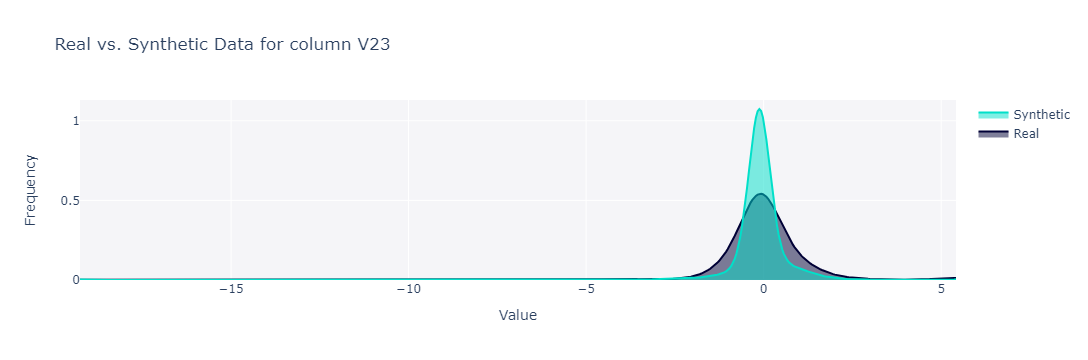

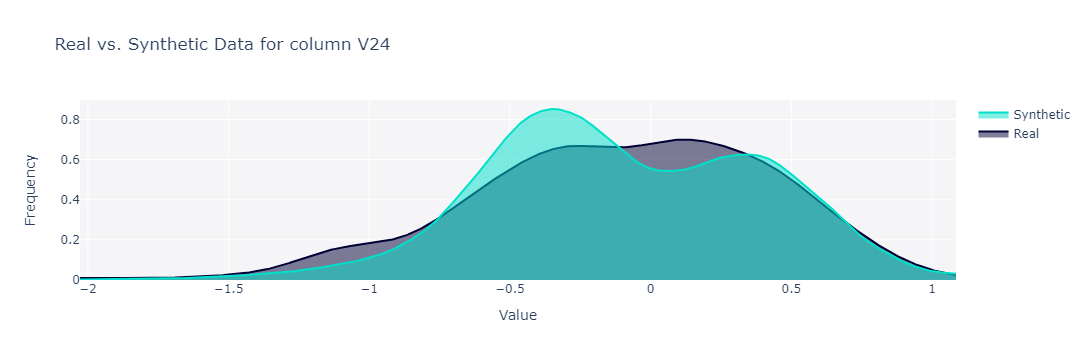

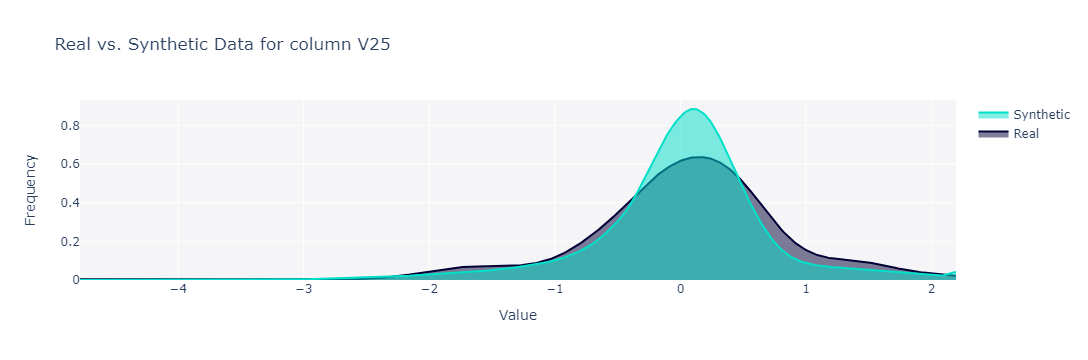

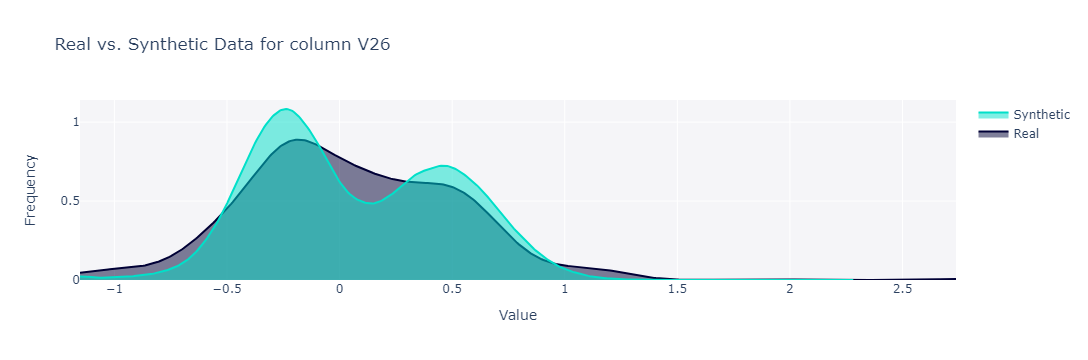

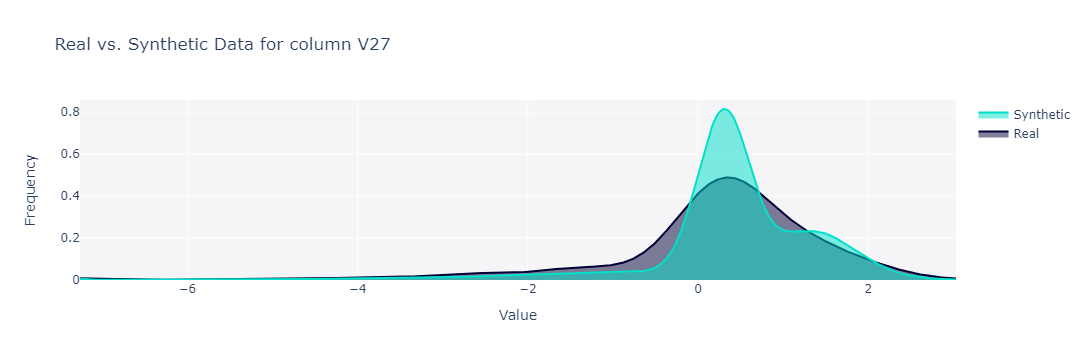

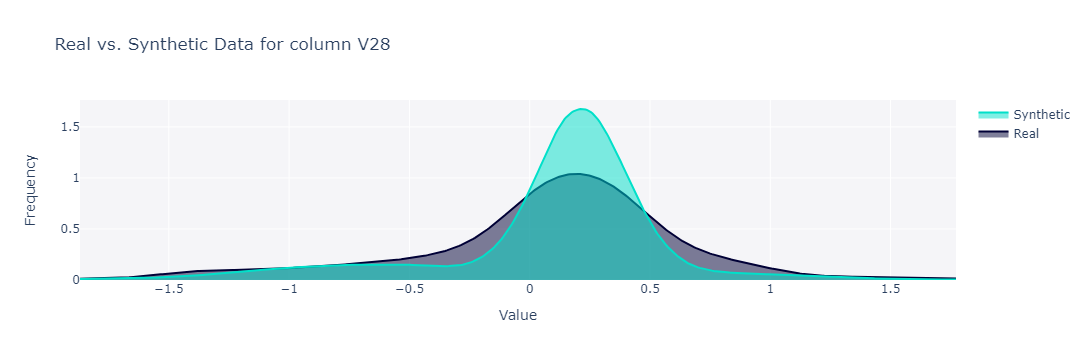

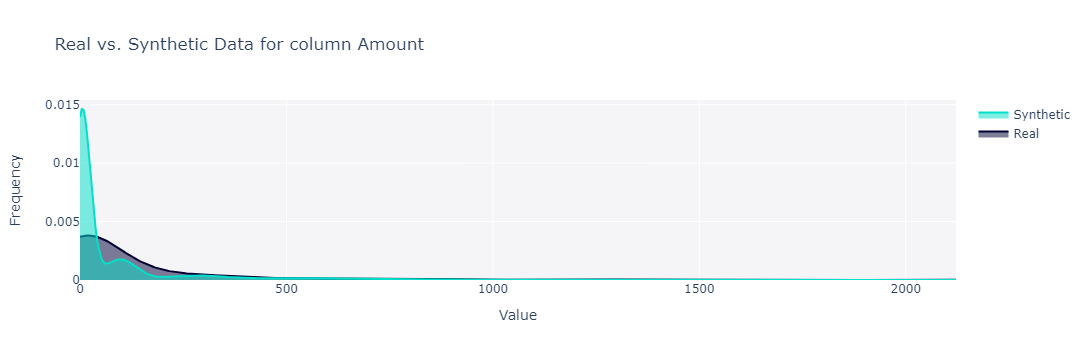

In [15]:
cols_list = df.columns[:-2]

real_data = df_fraud
quality_check(real_data, synthetic_data)

for column_name in cols_list:
    plot_dists(real_data, synthetic_data, column_name)

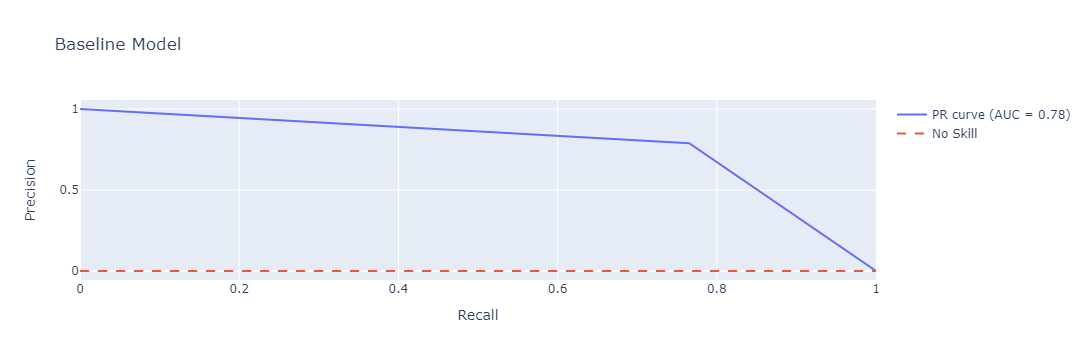

In [16]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/baseline_model.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df )
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Baseline Model")
delete_file()

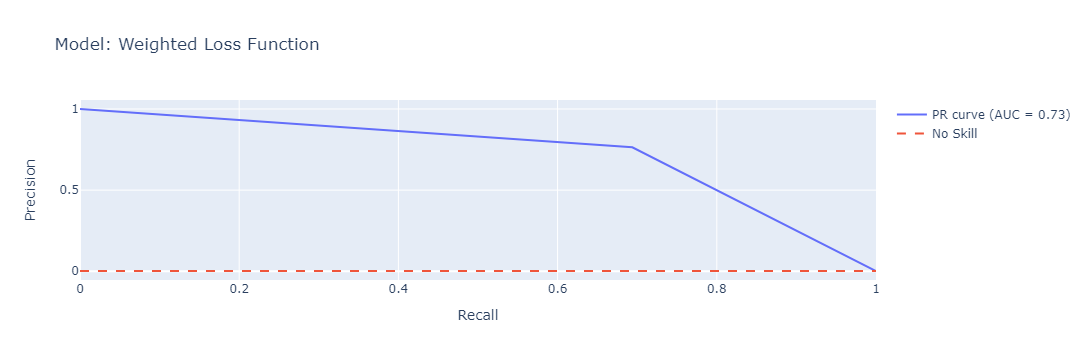

In [17]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_weighted_loss.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df )
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Weighted Loss Function")
delete_file()

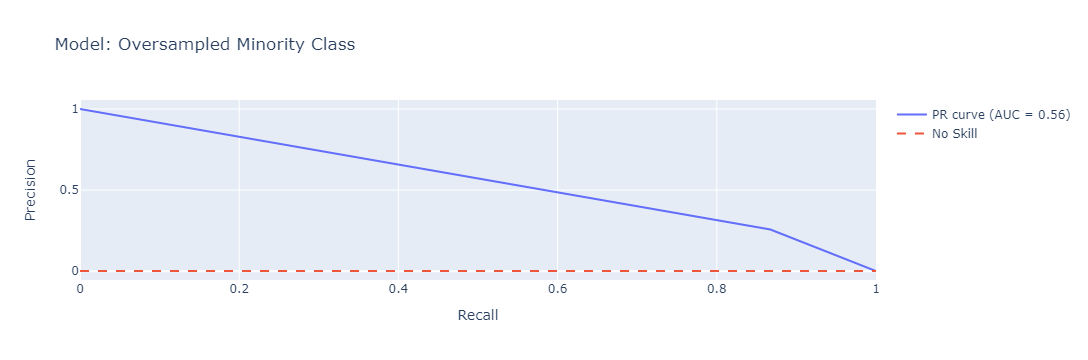

In [18]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_oversample.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df )
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Oversampled Minority Class")
delete_file()

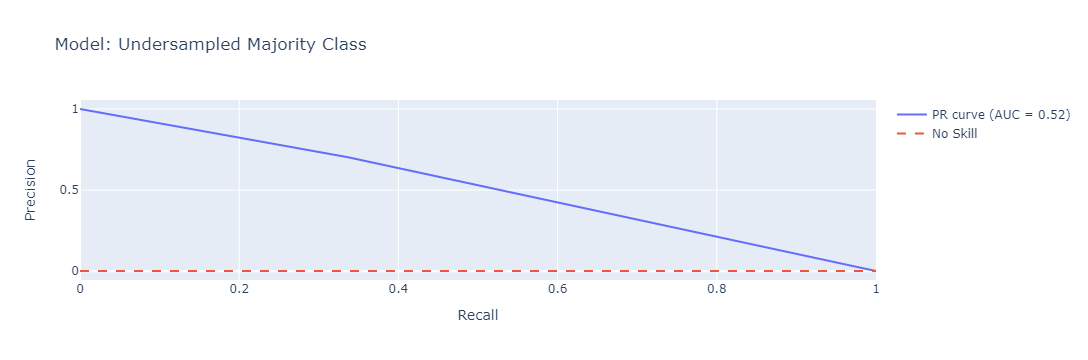

In [19]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_undersample.yaml'
train_df = train
model = run_experiment(url=model_url, train_df=train_df )
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Undersampled Majority Class")
delete_file()

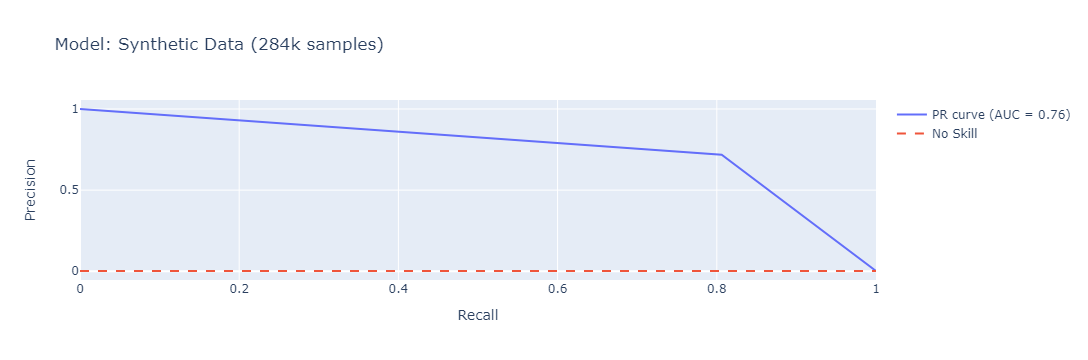

In [20]:
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/baseline_model.yaml'
train_df = train_with_synth
model = run_experiment(url=model_url, train_df=train_df)
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df, title="Model: Synthetic Data (284k samples)")
delete_file()

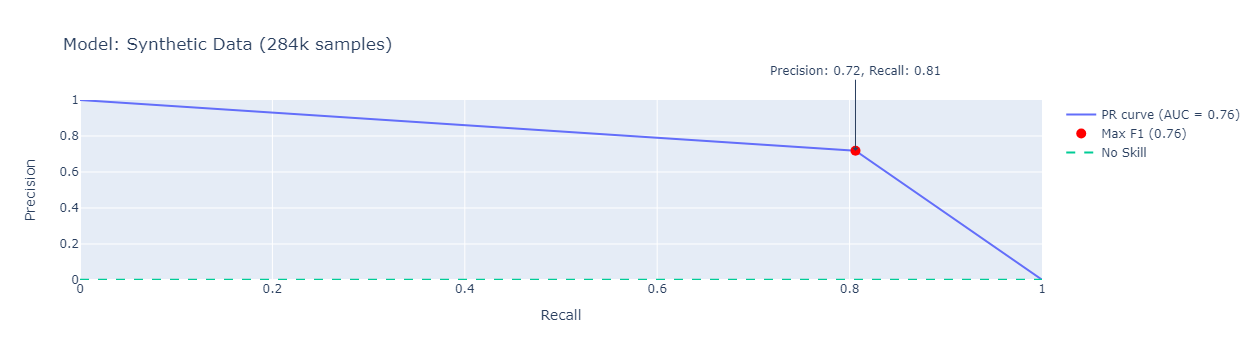

(0.7623189114326063,
 0.7596153846153846,
 0.7181818181818181,
 0.8061224489795918)

In [24]:
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def model_diagnostics(model_analysis_df, title):
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    pr_auc = auc(recall, precision)

    # Calculate F1 scores for each threshold
    f1_scores = 2*(recall * precision) / (recall + precision)
    # Get index of the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    max_precision = precision[max_f1_index]
    max_recall = recall[max_f1_index]

    # Create the Precision-Recall curve
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=recall, y=precision,
                             mode='lines',
                             name=f'PR curve (AUC = {pr_auc:.2f})'))

    # Mark the point with maximum F1 score
    fig.add_trace(go.Scatter(x=[max_recall], y=[max_precision],
                             mode='markers',
                             marker=dict(color='Red', size=10),
                             name=f'Max F1 ({max_f1:.2f})'))

    # Add annotation for precision and recall at max F1 score
    fig.add_annotation(x=max_recall, y=max_precision,
                       text=f'Precision: {max_precision:.2f}, Recall: {max_recall:.2f}',
                       showarrow=True,
                       arrowhead=1,
                       ax=0,
                       ay=-80)

    # Add random line
    no_skill = len(model_analysis_df['Class'][model_analysis_df['Class']==1]) / len(model_analysis_df['Class'])
    fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
                             mode='lines', 
                             name='No Skill', 
                             line=dict(dash='dash')))

    fig.update_xaxes(title_text="Recall")
    fig.update_yaxes(title_text="Precision", range=[0, 1])
    fig.update_layout(title_text=title, autosize=False)

    fig.show()

    # Return AUC and the values for the highest corner
    return pr_auc, max_f1, max_precision, max_recall



model_diagnostics(model_analysis_df, title="Model: Synthetic Data (284k samples)")
